# Observing Dark Worlds

## Goal:
Observing Dark World is a astrophysics problem of detecting positions of dark matter halos by using its gravitational lensing effect, typically meas it destort the light of background galaxy which passes close to the Dark Matter.
It's a hard problem because detecting dark matter is difficult and it's hard to recognize the distortion.
![Gravitational_Lensing](images/reorderdarkmatter.png)

## Data
To solve the position of the core of dark matter, we gather 300 telescope scan data, each telescope data contains 300 to 800 galaxy data. Each galaxy data are consist of x and y corrdinates and two ellipiticity data, represents the elongation of the galaxies, cased by the spacetime wrap from dark matter halos. (Salimans, 2012)

# imports

In [1]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import edward as ed
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import tensorflow.contrib.distributions as ds
from edward.models import Normal, Uniform, InverseGamma, Empirical, Categorical, Mixture
from tensorflow.contrib import slim
from edward.util import Progbar

# import data
* all_sky_star = []: skies
    * all_sky_star[i]: one sky
        * all_sky_star[i][0]: galaxy name
        * all_sky_star[i][1]: galaxy x position
        * all_sky_star[i][2]: galaxy y position
        * all_sky_star[i][3]: galaxy E1
        * all_sky_star[i][4]: galaxy E2
* all_sky_halo = []:halos
    * all_sky_halo[i] :halo for sky i
        * all_sky_halo[i][0]: sky name
        * all_sky_halo[i][1]: number of halos
        * all_sky_halo[i][2]: halo1 x
        * all_sky_halo[i][3]: halo1 y
        * ...
        * all_sky_halo[i][7]: halo3 y

In [2]:
num_of_sky = 300
file_path = "datasets"
all_sky_star = []

for sky in np.arange(1, num_of_sky + 1, 1):
    sky_path = "Train_Skies/Training_Sky" + str(sky) + ".csv"
    halo_path = "Training_halos.csv"
    star = pd.read_csv(file_path + "/" + sky_path)
    all_sky_star.append(star.values)
star.head()
#all_sky_halo = all_sky_halo.values


,GalaxyID,x,y,e1,e2
0,Galaxy1,1630.16,1027.12,-0.194881,0.045802
1,Galaxy2,1056.72,126.24,-0.235309,0.176257
2,Galaxy3,3903.84,2612.56,0.213914,-0.052132
3,Galaxy4,2120.96,2098.82,0.272938,-0.045578
4,Galaxy5,1549.02,2042.28,-0.507234,0.086598


In [3]:
all_sky_halo_data = pd.read_csv(file_path + "/" + halo_path)
all_sky_halo = all_sky_halo_data.values
all_sky_halo_data.head()


,SkyId,numberHalos,x_ref,y_ref,halo_x1,halo_y1,halo_x2,halo_y2,halo_x3,halo_y3
0,Sky1,1,1086.80,1114.61,1086.80,1114.61,0.0,0.0,0.0,0.0
1,Sky2,1,3477.71,1907.33,3477.71,1907.33,0.0,0.0,0.0,0.0
2,Sky3,1,2315.78,1081.95,2315.78,1081.95,0.0,0.0,0.0,0.0
3,Sky4,1,1408.61,1685.86,1408.61,1685.86,0.0,0.0,0.0,0.0
4,Sky5,1,3091.65,2001.08,3091.65,2001.08,0.0,0.0,0.0,0.0


# data processing
## single_sky_data
* sky_num = []:    No. of test sky
* single_sky_halo_xy: 2d position of halo in test sky
* single_sky_e1[i]:   e1 of i_th galaxy in test sky
* single_sky_e2[i]:   e2 of i_th galaxy in test sky
* single_sky_a1[i]:   a1 of i_th galaxy in test sky
* single_sky_a2[i]:   a2 of i_th galaxy in test sky

In [4]:
sky_num = 2
single_sky_halo_xy = np.array(all_sky_halo[sky_num, 2:4], dtype=np.float32)
single_sky_e1 = np.array(all_sky_star[sky_num][:, 3], dtype=np.float32)
single_sky_e2 = np.array(all_sky_star[sky_num][:, 4], dtype=np.float32)
l2_e1e2 = np.sqrt(single_sky_e1**2 + single_sky_e2**2)
q = ((1. + l2_e1e2) / (1 - l2_e1e2))**2
single_sky_a1 = np.sqrt(q / (1 + q))
single_sky_b1 = np.sqrt(1. / (1 + q))
single_sky_pos_xy = np.array(all_sky_star[sky_num][:, 1:3])
num_of_glxy = single_sky_pos_xy.shape[0]

# distribution check

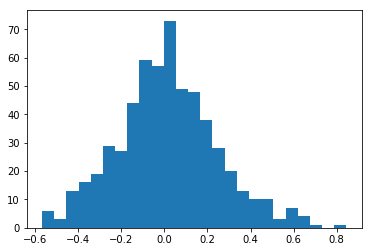

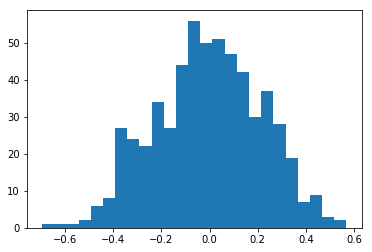

In [5]:
plt.clf()
plt.hist(single_sky_e1,25)
plt.show()
plt.hist(single_sky_e2,25)
plt.show()

# tangential funtion

In [6]:
def tangential(glxy_position, halo_position, axis):
    delta = glxy_position - halo_position
    t = 2 * tf.atan2(delta[:, 1], delta[:, 0])
    return -tf.cos(t) if axis == 0 else -tf.sin(t)

# Model 1

In [179]:
N = num_of_glxy
glxy_pos_xy = tf.placeholder(tf.float32, [N, 2])
# halo_pos_xy = Uniform(low=[0.,0.],high=[4200., 4200.])
halo_pos_xy = Normal(loc=tf.constant([2100., 2100.]), scale=tf.constant(20.0))
sigma = tf.constant(.05)  # InverseGamma(20.0, 1.0)
l2diff_halo_glxy = tf.sqrt(tf.reduce_sum(tf.square(glxy_pos_xy - halo_pos_xy),
                           reduction_indices=1))
sess = ed.get_session()
glxy_e1 = Normal(loc=tangential(glxy_pos_xy, halo_pos_xy, 0), scale=sigma)
glxy_e2 = Normal(loc=tangential(glxy_pos_xy, halo_pos_xy, 1), scale=sigma)

# Inference

## Variational Inference

In [147]:
def normal_qx():
    return Normal(tf.random_normal([2], mean=2100.), scale=tf.nn.softplus(
                  tf.Variable(tf.random_normal([2]))))


e1_in = single_sky_e1.reshape(N).tolist()
e2_in = single_sky_e2.reshape(N).tolist()
q_halo_pos_xy = normal_qx()
inference = ed.KLqp({halo_pos_xy: q_halo_pos_xy},
                    data={glxy_pos_xy: single_sky_pos_xy,
                    glxy_e1: e1_in, glxy_e2: e2_in})
inference.run(n_iter=10000, n_samples=10)

ValueError: cannot reshape array of size 641 into shape (578,)

# MCMC

In [181]:
# Inference
def constraints_normal(T):
    return tf.minimum(tf.maximum(tf.Variable(tf.random_normal([T, 2],
                      mean=[2100., 2100.], stddev=100.)), 0), 4200)
e1_in = single_sky_e1.reshape(N).tolist()
e2_in = single_sky_e2.reshape(N).tolist()

T = 1000
q_halo_pos_xy = Empirical(params=constraints_normal(T))
# qsig = Empirical(params=tf.Variable(tf.zeros(10000)))
inference = ed.SGHMC({halo_pos_xy: q_halo_pos_xy},
                     data={glxy_pos_xy: single_sky_pos_xy,
                     glxy_e1: e1_in, glxy_e2: e2_in})
inference.run(step_size=15.)

1000/1000 [100%] ██████████████████████████████ Elapsed: 13s | Acceptance Rate: 1.001


# Criticism

[ 2336.63208008  1216.4543457 ] [  19.40271568  112.43242645]


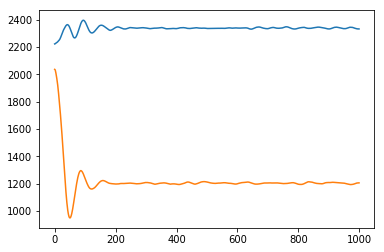

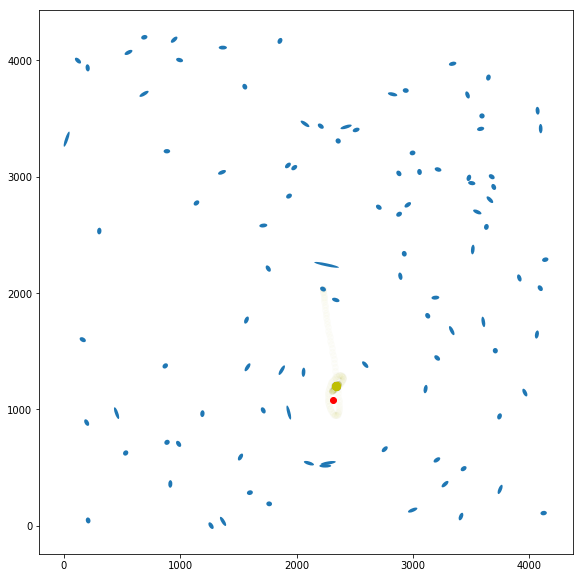

In [183]:
def draw_sky(galaxies):
    """adapted from Vishal Goklani"""
    size_multiplier = 45
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, aspect='equal')
    n = galaxies.shape[0]
    for i in range(n):
        _g = galaxies[i, :]
        x, y = _g[0], _g[1]
        d = np.sqrt(_g[2]**2 + _g[3]**2)
        a = 1.0 / (1 - d)
        b = 1.0 / (1 + d)
        theta = np.degrees(np.arctan2(_g[3], _g[2]) * 0.5)
        ax.add_patch(Ellipse(xy=(x, y), width=size_multiplier * a,
                     height=size_multiplier * b, angle=theta))
    ax.autoscale_view(tight=True)
    return fig

mean, stddev = sess.run([q_halo_pos_xy.mean(), q_halo_pos_xy.stddev()])
print(mean, stddev)
samples = sess.run(q_halo_pos_xy.params)
# plt.hist(samples, bins='auto')
# plt.show()

# Trace plot.
plt.plot(samples)
plt.show()
plt.clf()
fig = draw_sky(all_sky_star[sky_num][:100, 1:])
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.015, c="y")
plt.scatter(all_sky_halo[sky_num, 2], all_sky_halo[sky_num, 3], c="r")
plt.show()


# Criticism 2

3000/3000 [100%] ██████████████████████████████ Elapsed: 10s | Acceptance Rate: 1.000
[ 2243.95556641  1138.13537598] [ 358.6701355  227.1583252]
3000/3000 [100%] ██████████████████████████████ Elapsed: 9s | Acceptance Rate: 1.000
[ 2275.77124023  1210.63464355] [ 298.45257568   31.00737572]
3000/3000 [100%] ██████████████████████████████ Elapsed: 8s | Acceptance Rate: 1.000
[ 2257.42456055  1261.59765625] [ 337.16680908  220.67985535]
3000/3000 [100%] ██████████████████████████████ Elapsed: 9s | Acceptance Rate: 1.000
[  905.04266357  3163.9597168 ] [ 81.71781158  67.2808075 ]
3000/3000 [100%] ██████████████████████████████ Elapsed: 10s | Acceptance Rate: 1.000
[ 2322.36425781  1184.95324707] [ 111.49421692  114.19600677]
3000/3000 [100%] ██████████████████████████████ Elapsed: 11s | Acceptance Rate: 1.000
[ 2325.65600586  1207.46240234] [ 105.15981293   25.94026184]
3000/3000 [100%] ██████████████████████████████ Elapsed: 9s | Acceptance Rate: 1.000
[ 2314.50268555  1234.7565918 ] [ 

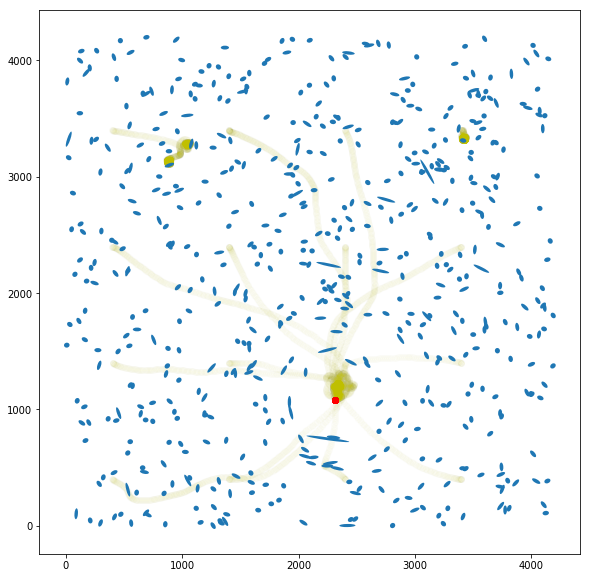

In [143]:
plt.clf()
fig = draw_sky(all_sky_star[sky_num][:, 1:])
for i in np.arange(400, 4001, 1000):
    for j in np.arange(400, 4001, 1000):
        def constraints_normal(T):
            return tf.minimum(tf.maximum(tf.Variable(tf.random_normal(
                              [T, 2], mean=[i, j], stddev=1.)), 0), 4200)

        T = 3000
        q_halo_pos_xy = Empirical(params=constraints_normal(T))
        # qsig = Empirical(params=tf.Variable(tf.zeros(10000)))
        inference = ed.SGHMC({halo_pos_xy: q_halo_pos_xy},
                             data={glxy_pos_xy: single_sky_pos_xy,
                             glxy_e1: e1_in, glxy_e2: e2_in})
        inference.run(step_size=5.)

        mean, stddev = sess.run([q_halo_pos_xy.mean(), q_halo_pos_xy.stddev()])
        print(mean, stddev)
        samples = sess.run(q_halo_pos_xy.params)
        # plt.hist(samples, bins='auto')
        # plt.show()

        # Trace plot.
        # plt.plot(samples)
        # plt.show()

        plt.scatter(samples[0:, 0], samples[0:, 1], alpha=0.015, c="y")
        plt.scatter(all_sky_halo[sky_num, 2], all_sky_halo[sky_num, 3], c="r")
plt.show()


# Neural Network for distance funtion

## concatnate data

In [6]:
all_sky_glxy_no = [0]
sky0_e1 = np.array(all_sky_star[0][:,3],dtype=np.float32)
sky0_e2 = np.array(all_sky_star[0][:,4],dtype=np.float32)
sq = np.sqrt(sky0_e1**2+sky0_e2**2)
q = ((1.+sq)/(1-sq))**2
sky0_a1 = np.sqrt(q/(1+q))
sky0_b1 = np.sqrt(1./(1+q))
select = sky0_a1/sky0_b1>-100
select = select.reshape(select.shape[0])
conc_glxy_xy = all_sky_star[0][select,1:3]
conc_halo_xy = np.ones(all_sky_star[0][select,1:3].shape)*all_sky_halo[0,2:4]
conc_glxy_e1_e2 = all_sky_star[0][select,3:5]
all_sky_glxy_no.append(conc_glxy_xy.shape[0])

for sky2 in np.arange(1,300,1):
    e1,e2 = np.array(all_sky_star[sky2][:,3:4],dtype=np.float32),np.array(all_sky_star[sky2][:,4:5],dtype=np.float32)
    sq = np.sqrt(e1**2+e2**2)
    q = ((1.+sq)/(1-sq))**2
    a1 = np.sqrt(q/(1+q))
    b1 = np.sqrt(1./(1+q))
    select = a1/b1>-100
    select = select.reshape(select.shape[0])
    conc_glxy_xy = np.concatenate((conc_glxy_xy,all_sky_star[sky2][select,1:3]),axis = 0)
    conc_glxy_e1_e2 = np.concatenate((conc_glxy_e1_e2,all_sky_star[sky2][select,3:5]),axis = 0)    
    conc_halo_xy = np.concatenate((conc_halo_xy,np.ones(all_sky_star[sky2][select,1:3].shape)*all_sky_halo[sky2,2:4]),axis = 0)
    all_sky_glxy_no.append(conc_glxy_xy.shape[0])
print(conc_glxy_xy.shape)
print(conc_halo_xy.shape)
print(conc_glxy_e1_e2.shape)
num_all_glxy = conc_glxy_xy.shape[0]
print(all_sky_glxy_no)

(160842, 2)
(160842, 2)
(160842, 2)
[0, 348, 937, 1515, 2045, 2480, 3094, 3582, 4174, 4748, 5086, 5806, 6417, 7094, 7487, 7993, 8343, 9035, 9734, 10360, 11011, 11580, 12289, 13000, 13319, 13869, 14518, 15147, 15850, 16505, 17022, 17351, 17954, 18320, 18999, 19475, 20156, 20649, 21041, 21390, 21801, 22442, 23160, 23582, 24229, 24551, 25135, 25508, 25999, 26686, 27416, 27949, 28668, 29050, 29532, 29890, 30420, 30762, 31391, 31758, 32355, 32906, 33326, 33815, 34170, 34773, 35509, 36126, 36496, 36848, 37460, 37836, 38468, 38997, 39514, 39879, 40241, 40649, 41312, 41639, 41998, 42710, 43179, 43805, 44186, 44760, 45145, 45497, 46130, 46863, 47506, 48148, 48858, 49531, 49980, 50685, 51130, 51803, 52159, 52591, 52982, 53547, 54181, 54754, 55281, 55864, 56600, 56969, 57623, 58080, 58506, 59138, 59749, 60470, 61091, 61720, 62345, 62873, 63279, 63865, 64448, 65121, 65466, 66140, 66596, 67227, 67620, 68198, 68714, 69202, 69699, 70422, 70749, 71457, 72049, 72632, 73216, 73644, 74177, 74713, 75279, 

In [7]:
N = num_all_glxy

# Model

glxy_pos_xy = tf.placeholder(tf.float32, [N, 2])

# halo_pos_xy = Uniform(low=[0.,0.],high=[4200., 4200.])
halo_pos_xy = tf.placeholder(tf.float32, [N, 2])
# halo_pos_xy = [2315.61, 1082.86]
# m = Uniform(low=10.,high=1000.)
m = 100

l2diff = tf.sqrt(tf.reduce_sum(tf.square(glxy_pos_xy - halo_pos_xy), reduction_indices=1))/4200.

sess = ed.get_session()

w0 = Normal(loc=tf.zeros(1), scale=tf.ones(1))
b0 = Normal(loc=tf.zeros(1), scale=tf.ones(1))
w1 = Normal(loc=tf.zeros(1), scale=tf.ones(1))
#b1 = Normal(loc=tf.zeros(1), scale=tf.ones(1))
w2 = Normal(loc=tf.zeros(1), scale=tf.ones(1))
#b2 = Normal(loc=tf.zeros(1), scale=tf.ones(1))
#b3 = Normal(loc=tf.zeros(1), scale=tf.ones(1))
y = Normal(loc=(tf.multiply(l2diff**(-1),w0) + tf.multiply(l2diff**(1), w1) + tf.multiply(l2diff**(2), w2) + b0), scale=tf.ones(N))
mu =y

e1_var = tf.multiply(tangential(glxy_pos_xy, halo_pos_xy , 0),mu)
e2_var = tf.multiply(tangential(glxy_pos_xy, halo_pos_xy , 1),mu)
sess2 =tf.Session()



# inference ii

In [116]:
e1_in = conc_glxy_e1_e2[:,0].reshape(N).tolist()
e2_in = conc_glxy_e1_e2[:,1].reshape(N).tolist()

qw0 = Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))
qb0 = Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))
qw1 = Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))
qb1 = Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))
qw2 = Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))
qb2 = Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))
qb3 = Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))
             
inference = ed.KLqp({w0: qw0, b0: qb0, w1: qw1, w2: qw2}, data={halo_pos_xy: conc_halo_xy, glxy_pos_xy: conc_glxy_xy,
                     e1_var: e1_in, e2_var: e2_in})
inference.run(n_samples=5, n_iter=1000)

1000/1000 [100%] ██████████████████████████████ Elapsed: 11s | Loss: -0.000


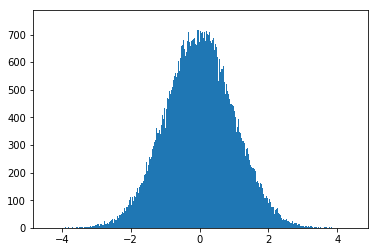

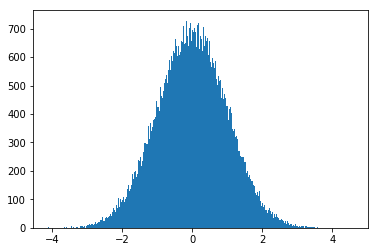

Tensor("Mul_61:0", shape=(50845,), dtype=float32)


In [117]:
def visualise(X_data, y_data, w, b, n_samples=10):
    w_samples = w.sample(n_samples)[:, 0].eval()
    b_samples = b.sample(n_samples).eval()
    plt.scatter(X_data[:, 0], y_data)
    inputs = np.linspace(-8, 8, num=400)
    for ns in range(n_samples):
        output = inputs * w_samples[ns] + b_samples[ns]
        plt.plot(inputs, output)
    plt.show()
#visualise(e1_e2[:,:1], e1_e2[:,1:], qw0, qb0)

w_samples = qw2.sample(100000)[:, 0].eval()
plt.hist(w_samples,500)
plt.show()
w_samples =w2.sample(100000)[:, 0].eval()
plt.hist(w_samples,500)
plt.show()
print(e1_var)

# model iv

## data convert

In [8]:
all_sky_xy_e1e2 = np.concatenate((conc_glxy_xy/4200., conc_glxy_e1_e2),axis = 1)
conc_glxy_halo_d_xy = (conc_glxy_xy - conc_halo_xy)/4200.
all_sky_glxy_halo_r = (np.sum(conc_glxy_halo_d_xy**2 ,axis = 1))**(1/2.)
#all_sky_glxy_halo_p = np.arctan2(conc_glxy_halo_d_xy[:,0].astype(dtype = np.float64),conc_glxy_halo_d_xy[:,1].astype(dtype = np.float64))
all_sky_glxy_halo_p = np.arctan(conc_glxy_halo_d_xy[:,0].astype(dtype = np.float64)/conc_glxy_halo_d_xy[:,1].astype(dtype = np.float64))
print(all_sky_glxy_halo_p)

[ 0.36021912 -0.21064001 -1.08612662 ..., -0.16496581  0.65278603
  0.20238689]


## sub sampling

(160842, 6)
(3563, 6)
(5604, 6)
(7280, 6)
(8552, 6)
(9674, 6)
(10508, 6)
(11039, 6)
(11453, 6)
(11514, 6)
(11497, 6)
(10831, 6)
(10168, 6)
(9297, 6)
(8473, 6)
(7434, 6)
(6444, 6)
(5429, 6)
(3979, 6)
(2815, 6)
(1768, 6)
(100021, 6)


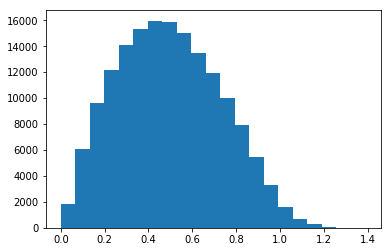

In [9]:

all_sky_xy_e1e2_r_p = np.concatenate((all_sky_xy_e1e2,all_sky_glxy_halo_r.reshape(all_sky_glxy_halo_r.shape[0],1)),axis=1)
all_sky_xy_e1e2_r_p = np.concatenate((all_sky_xy_e1e2_r_p,all_sky_glxy_halo_p.reshape(all_sky_glxy_halo_p.shape[0],1)),axis=1)
print(all_sky_xy_e1e2_r_p.shape)
# for i np.arange(0,)
l = all_sky_xy_e1e2_r_p[0].reshape(1,6)
select = all_sky_xy_e1e2_r_p[:,4]<200/4200.
for i in np.arange(240,4200,200):
    select_low = all_sky_xy_e1e2_r_p[:,4]>(i/4200.)
    select_hi = all_sky_xy_e1e2_r_p[:,4]<(i+200)/4200.
    select = select_low & select_hi
    sample = all_sky_xy_e1e2_r_p[select]
    l2 = sample[0].reshape(1,6)
    for j in range(5000):
        ran = np.random.randint(0,sample.shape[0])
        l2 = np.concatenate((l2, sample[ran].reshape(1,6)))
    l = np.concatenate((l, l2))   
    print(sample.shape)
#test = all_sky_xy_e1e2_r_p[select]
print(l.shape)
#print(test.shape)
plt.hist(all_sky_glxy_halo_r.tolist(),21)
plt.show()

sample_all_sky_xy_e1e2 = l[:,:4]
sample_all_sky_glxy_halo_r = l[:,4]
sample_all_sky_glxy_halo_p = l[:,5]

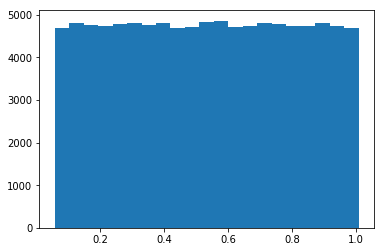

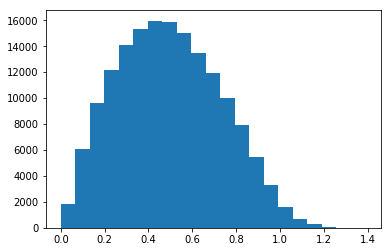

In [10]:
plt.hist(sample_all_sky_glxy_halo_r.tolist(),21)
plt.show()
plt.hist(all_sky_glxy_halo_r.tolist(),21)
plt.show()

In [11]:
N = num_all_glxy
in_data = tf.placeholder(tf.float32, [None, 4],name = "in")
out_r = tf.placeholder(tf.float32, [None])
out_p = tf.placeholder(tf.float32, [None])
def neural_network(input_x):
    hidden1 = slim.fully_connected(input_x, 200)
    hidden2 = slim.fully_connected(hidden1, 50)
    locs_r = slim.fully_connected(hidden2, K, activation_fn=None)
    scales_r = slim.fully_connected(hidden2, K, activation_fn=tf.exp)
    logits_r = slim.fully_connected(hidden2, K, activation_fn=None)
    locs_p = slim.fully_connected(hidden2, K, activation_fn=None)
    scales_p = slim.fully_connected(hidden2, K, activation_fn=tf.exp)
    logits_p = slim.fully_connected(hidden2, K, activation_fn=None)
    return locs_r, scales_r, logits_r, locs_p, scales_p, logits_p

K = 6

locs_r, scales_r, logits_r, locs_p, scales_p, logits_p = neural_network(in_data)
cat_r = Categorical(logits=logits_r)
components_r = [Normal(loc=loc, scale=scale) for loc, scale
              in zip(tf.unstack(tf.transpose(locs_r)),
                     tf.unstack(tf.transpose(scales_r)))]
r = Mixture(cat=cat_r, components=components_r, value=tf.zeros_like(out_r))
cat_p = Categorical(logits=logits_p)
cat_p = Categorical(logits=logits_p)
components_p = [Normal(loc=loc, scale=scale) for loc, scale
              in zip(tf.unstack(tf.transpose(locs_p)),
                     tf.unstack(tf.transpose(scales_p)))]
p = Mixture(cat=cat_p, components=components_p, value=tf.zeros_like(out_p))

# inference iv

In [12]:
inference = ed.MAP(data={r: out_r, p:out_p})
optimizer = tf.train.AdamOptimizer(5e-3)
inference.initialize(optimizer=optimizer, var_list=tf.trainable_variables())

sess = ed.get_session()
tf.global_variables_initializer().run()

In [18]:
n_epoch = 300
train_loss = np.zeros(n_epoch)
test_loss = np.zeros(n_epoch)
for i in range(n_epoch):
  info_dict = inference.update(feed_dict={in_data: all_sky_xy_e1e2, out_r: all_sky_glxy_halo_r,out_p: all_sky_glxy_halo_p })
  train_loss[i] = info_dict['loss']
  test_loss[i] = sess.run(inference.loss, feed_dict={in_data: all_sky_xy_e1e2, out_r: all_sky_glxy_halo_r,out_p: all_sky_glxy_halo_p })
  inference.print_progress(info_dict)

 300/1000 [ 30%] █████████                      ETA: 596s | Loss: 74165.297

In [13]:
# train on resampled data
n_epoch = 300
train_loss = np.zeros(n_epoch)
test_loss = np.zeros(n_epoch)
for i in range(n_epoch):
  info_dict = inference.update(feed_dict={in_data: sample_all_sky_xy_e1e2, out_r: sample_all_sky_glxy_halo_r,out_p: sample_all_sky_glxy_halo_p })
  train_loss[i] = info_dict['loss']
  test_loss[i] = sess.run(inference.loss, feed_dict={in_data: sample_all_sky_xy_e1e2, out_r: sample_all_sky_glxy_halo_r,out_p: sample_all_sky_glxy_halo_p })
  inference.print_progress(info_dict)

 300/1000 [ 30%] █████████                      ETA: 595s | Loss: 74545.562

In [23]:
#train on near data
n_epoch = 300
train_loss = np.zeros(n_epoch)
test_loss = np.zeros(n_epoch)
select =all_sky_glxy_halo_r<1500/4200.
near_all_sky_xy_e1e2 = all_sky_xy_e1e2[select,:]
near_all_sky_glxy_halo_r = all_sky_glxy_halo_r[select]
near_all_sky_glxy_halo_p =all_sky_glxy_halo_p[select]
for i in range(n_epoch):
  info_dict = inference.update(feed_dict={in_data: near_all_sky_xy_e1e2, out_r: near_all_sky_glxy_halo_r,out_p: near_all_sky_glxy_halo_p })
  train_loss[i] = info_dict['loss']
  inference.print_progress(info_dict)
# print(near_all_sky_xy_e1e2)

 300/1000 [ 30%] █████████                      ETA: 226s | Loss: 857.734 

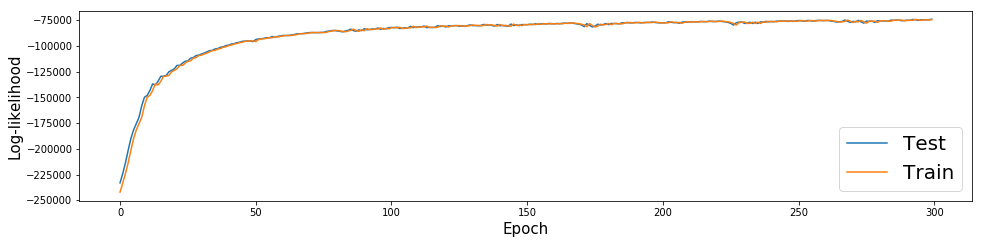

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 3.5))
plt.plot(np.arange(n_epoch), -test_loss , label='Test')
plt.plot(np.arange(n_epoch), -train_loss , label='Train')
plt.legend(fontsize=20)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Log-likelihood', fontsize=15)
plt.show()

In [16]:
pred_weights_r, pred_means_r, pred_std_r = sess.run(
    [tf.nn.softmax(logits_r), locs_r, scales_r], feed_dict={in_data: all_sky_xy_e1e2[all_sky_glxy_no[2]:all_sky_glxy_no[3],:]})
pred_weights_p, pred_means_p, pred_std_p = sess.run(
[tf.nn.softmax(logits_p), locs_p, scales_p], feed_dict={in_data: all_sky_xy_e1e2[all_sky_glxy_no[2]:all_sky_glxy_no[3],:]})
print(all_sky_xy_e1e2*4200.)
print(all_sky_xy_e1e2[all_sky_glxy_no[4]]*4200.)
print(all_sky_xy_e1e2[2]*4200.)
print(all_sky_glxy_no[1])

[[700.87 89.98 -212.3898 -1265.1996]
 [570.74 3528.23 -1045.6866 218.60160000000002]
 [579.66 1381.65 2031.8088 255.74219999999997]
 ..., 
 [2287.49 2051.11 -392.385 1197.3906]
 [1782.45 289.08 487.7292 -556.0968]
 [3060.91 4181.84 270.4128 -24.423]]
[2647.5 928.02 -753.396 44.3352]
[579.66 1381.65 2031.8088 255.74219999999997]
348


In [17]:
pred_weights_r.shape[0]
r_list = []
pbar = Progbar(600)
for i in range(300):
    pbar.update(i)
    components_r = [Normal(loc=loc, scale=scale) for loc, scale
                    in zip(tf.unstack(tf.transpose(pred_means_r[i])),
                     tf.unstack(tf.transpose(pred_std_r[i])))]
    cat_r = Categorical(logits=pred_weights_r[i])
    r = Mixture(cat=cat_r, components=components_r, value=tf.zeros_like(out_r[i]))
    r_list.append(r)
# logprob = 0.
# r.prob(1.).eval()
pred_weights_p.shape[0]
p_list = []
for i in range(300):
    pbar.update(301+i)
    components_p = [Normal(loc=loc, scale=scale) for loc, scale
                    in zip(tf.unstack(tf.transpose(pred_means_p[i])),
                     tf.unstack(tf.transpose(pred_std_p[i])))]
    cat_p = Categorical(logits=pred_weights_p[i])
    p= Mixture(cat=cat_p, components=components_p, value=tf.zeros_like(out_p[i]))
    p_list.append(p)


600/600 [100%] ██████████████████████████████ Elapsed: 124s


In [27]:
def r_t_glxy_halo(glxy_xy,halo_xy):
    extended_halo_xy = np.ones(glxy_xy.shape)*halo_xy
    distance = glxy_xy-halo_xy
    r = (np.sum(distance**2,axis = 1))**(1/2.)
    p = np.arctan((distance[:,0]/distance[:,1]).astype(dtype = np.float64))
    return r,p
print(r_t_glxy_halo(np.array([[1.,1.],[1.,2.],[2.,2.]]),np.array([0.,0.])))

(array([ 1.41421356,  2.23606798,  2.82842712]), array([ 0.78539816,  0.46364761,  0.78539816]))


(420,) (420,)


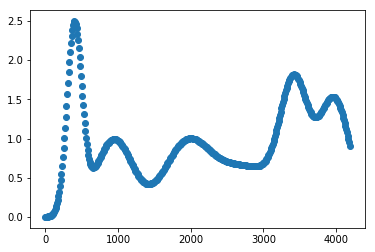

[691.78 4199.06 650.3532 348.936]


In [25]:
g = 8
a = np.arange(1,4200,10)/4200.
b = r_list[g].prob(a.tolist()).eval()
print(a.shape, b.shape)
plt.scatter((a*4200.).tolist(), b.tolist())
plt.show()
s = all_sky_xy_e1e2[all_sky_glxy_no[2]:all_sky_glxy_no[3]]
print(s[g]*4200.)
# print(r_list[0].prob(1. ).eval())

In [ ]:
print(r_list[1].prob([[0.1,0.2],[0.3,0.4]]).eval())

In [23]:
def create_grid(halo_step):
    l = []
    for i in np.arange(int(halo_step/2), 4200, halo_step):
        l2 = []
        for j in np.arange(int(halo_step/2), 4200, halo_step):
            l2.append([i,j])
        l.append(l2)
    return l
grid_20 = np.array(create_grid(20))
dis = np.array(create_grid(20))

def grid_glxy_l2diff(grid, glxy_xy):
    distance = grid - glxy_xy
    l2diff_mat = (np.sum(distance**2,axis=2))**(1/2)
    return l2diff_mat

def grid_glxy_arctan(grid, glxy_xy):
    distance = grid - glxy_xy
    return np.arctan((distance[:,:,0]/distance[:,:,1]).astype(dtype = np.float64))

def grid_glxy_arctan2(grid, glxy_xy):
    distance = grid - glxy_xy
    return np.arctan2(distance[:,:,0].astype(dtype = np.float64),distance[:,:,1].astype(dtype = np.float64))


ata = grid_glxy_arctan(grid_20, [0., 0.])
print(ata.shape)

(210, 210)


In [32]:
g = 15
dis = grid_glxy_l2diff(grid_20, all_sky_star[2][g][1:3])/4200.
atan = grid_glxy_arctan(grid_20, all_sky_star[2][g][1:3])
b2d = r_list[g].prob(dis.tolist()).eval()
c2d = p_list[g].prob(atan.tolist()).eval()
#print(a.shape, b.shape)
plt.matshow(c2d)
#plt.savefig("what.pdf")
plt.show()
print(all_sky_star[2][g][1:3])

TypeError: Image data cannot be converted to float

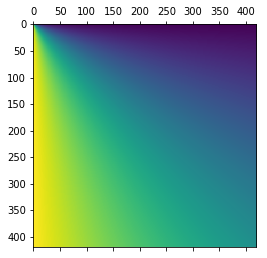

In [136]:
plt.clf()
plt.matshow(ata)
plt.show()

  0/300 [  0%]                                ETA: 0s

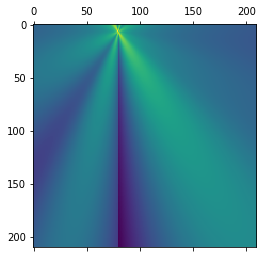

  1/300 [  0%]                                ETA: 1514s

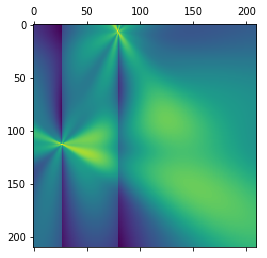

  2/300 [  0%]                                ETA: 1531s

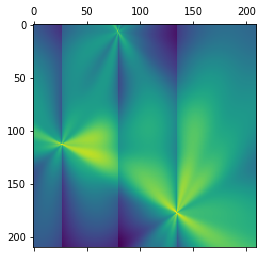

  3/300 [  1%]                                ETA: 1549s

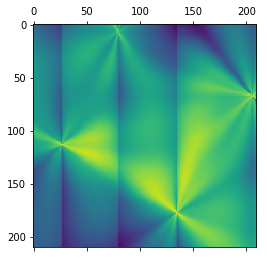

  4/300 [  1%]                                ETA: 1538s

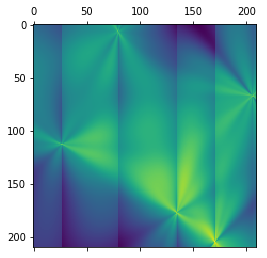

  5/300 [  1%]                                ETA: 1532s

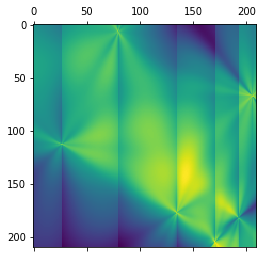

  6/300 [  2%]                                ETA: 1529s

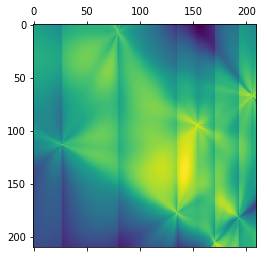

  7/300 [  2%]                                ETA: 1524s

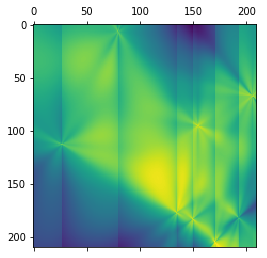

  8/300 [  2%]                                ETA: 1526s

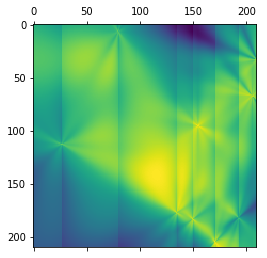

  9/300 [  3%]                                ETA: 1538s

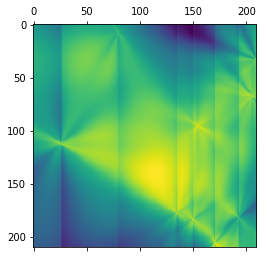

 10/300 [  3%] █                              ETA: 1535s

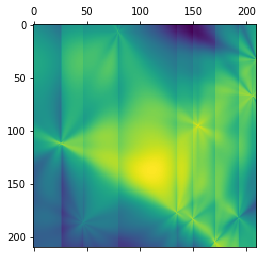

 11/300 [  3%] █                              ETA: 1524s

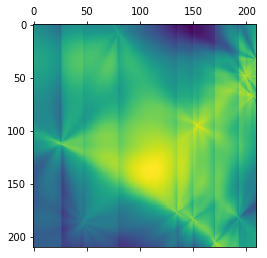

 12/300 [  4%] █                              ETA: 1518s

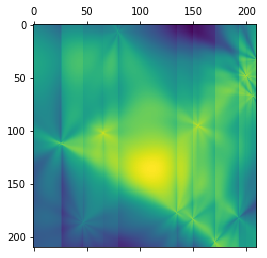

 13/300 [  4%] █                              ETA: 1526s

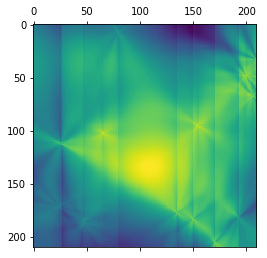

 14/300 [  4%] █                              ETA: 1520s

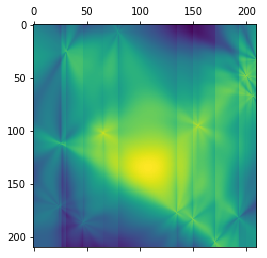

 15/300 [  5%] █                              ETA: 1521s

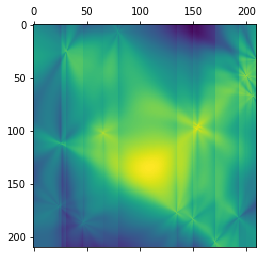

 16/300 [  5%] █                              ETA: 1522s

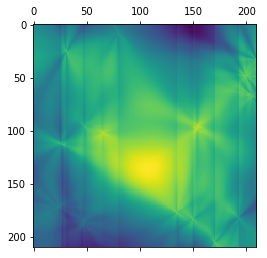

 17/300 [  5%] █                              ETA: 1514s

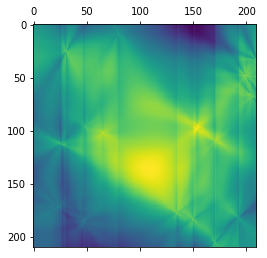

 18/300 [  6%] █                              ETA: 1505s

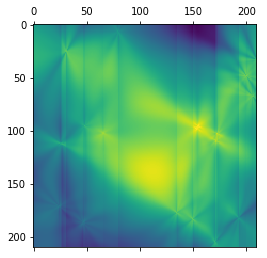

 19/300 [  6%] █                              ETA: 1495s

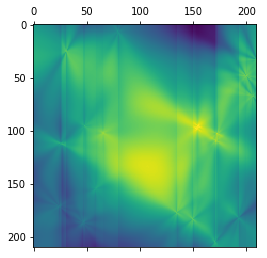

 20/300 [  6%] ██                             ETA: 1487s

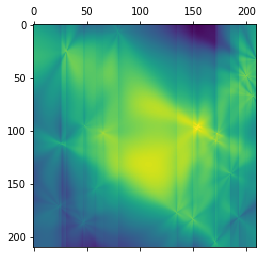

 21/300 [  7%] ██                             ETA: 1483s

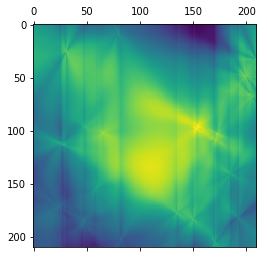

 22/300 [  7%] ██                             ETA: 1483s

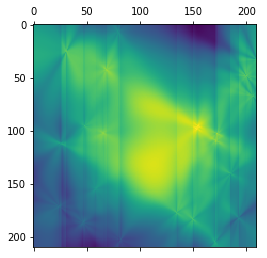

 23/300 [  7%] ██                             ETA: 1484s

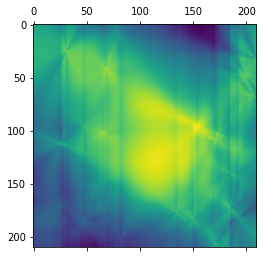

 24/300 [  8%] ██                             ETA: 1489s

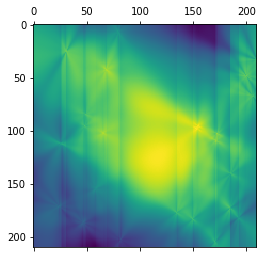

 25/300 [  8%] ██                             ETA: 1496s

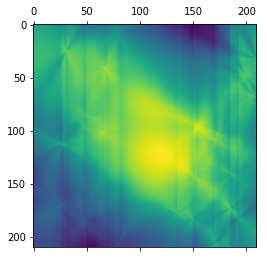

 26/300 [  8%] ██                             ETA: 1494s

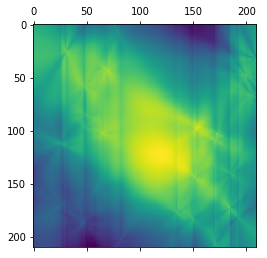

 27/300 [  9%] ██                             ETA: 1485s

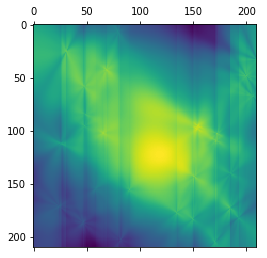

 28/300 [  9%] ██                             ETA: 1477s

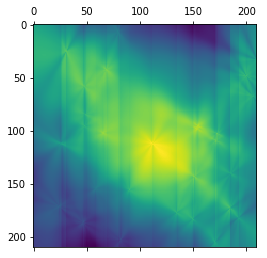

 29/300 [  9%] ██                             ETA: 1473s

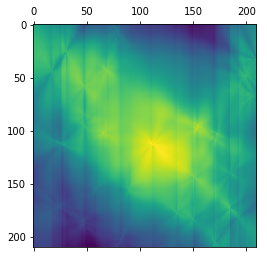

 30/300 [ 10%] ███                            ETA: 1467s

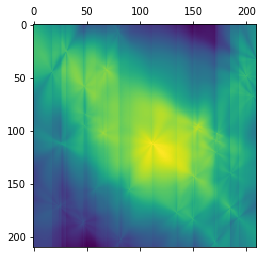

 31/300 [ 10%] ███                            ETA: 1461s

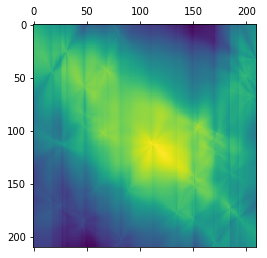

 32/300 [ 10%] ███                            ETA: 1461s

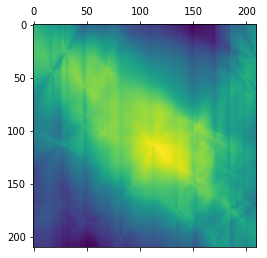

 33/300 [ 11%] ███                            ETA: 1461s

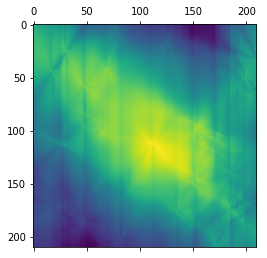

 34/300 [ 11%] ███                            ETA: 1460s

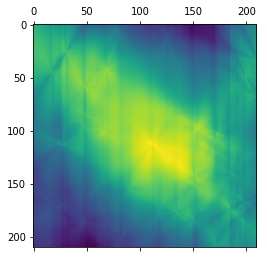

 35/300 [ 11%] ███                            ETA: 1455s

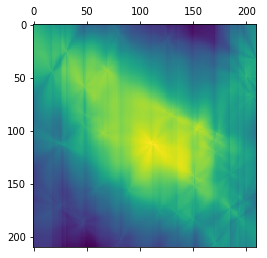

 36/300 [ 12%] ███                            ETA: 1449s

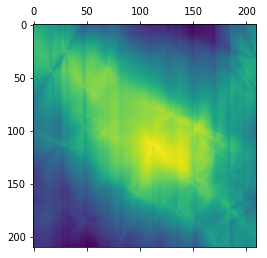

 37/300 [ 12%] ███                            ETA: 1445s

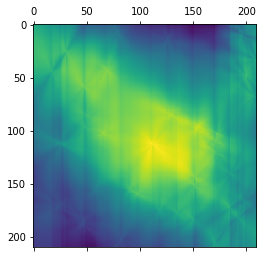

 38/300 [ 12%] ███                            ETA: 1438s

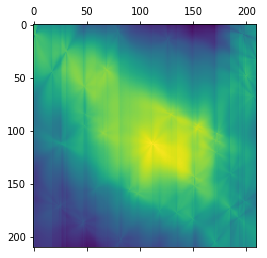

 39/300 [ 13%] ███                            ETA: 1434s

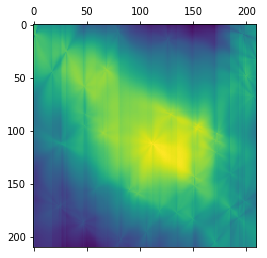

 40/300 [ 13%] ████                           ETA: 1427s

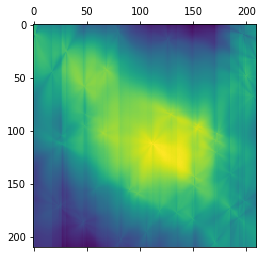

 41/300 [ 13%] ████                           ETA: 1421s

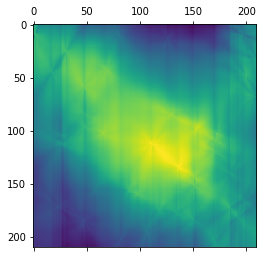

 42/300 [ 14%] ████                           ETA: 1414s

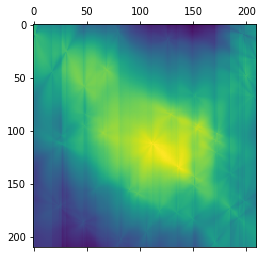

 43/300 [ 14%] ████                           ETA: 1409s

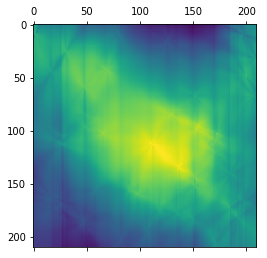

 44/300 [ 14%] ████                           ETA: 1402s

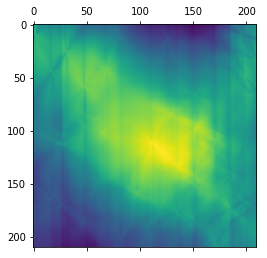

 45/300 [ 15%] ████                           ETA: 1396s

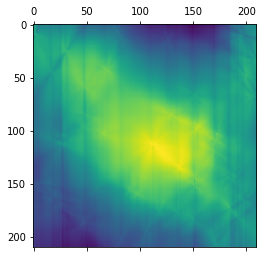

 46/300 [ 15%] ████                           ETA: 1390s

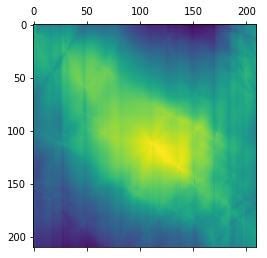

 47/300 [ 15%] ████                           ETA: 1384s

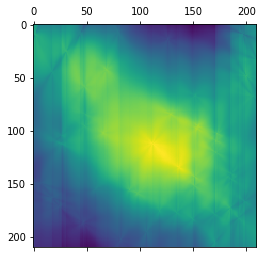

 48/300 [ 16%] ████                           ETA: 1379s

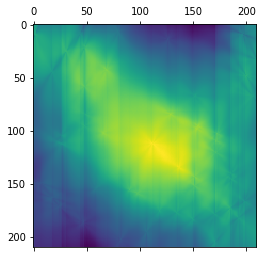

 49/300 [ 16%] ████                           ETA: 1372s

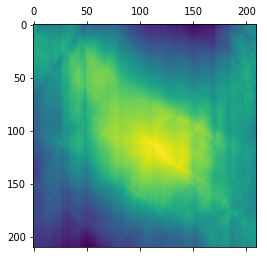

 50/300 [ 16%] █████                          ETA: 1366s

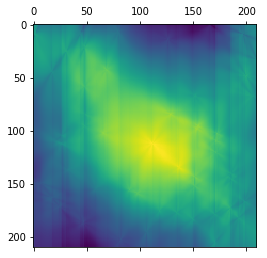

 51/300 [ 17%] █████                          ETA: 1361s

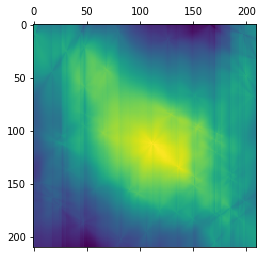

 52/300 [ 17%] █████                          ETA: 1356s

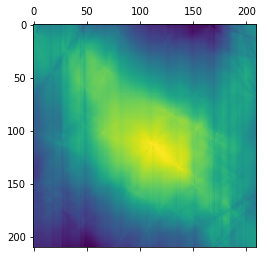

 53/300 [ 17%] █████                          ETA: 1354s

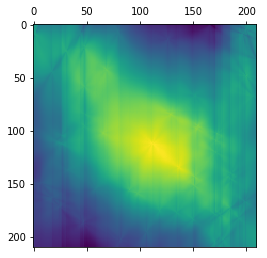

 54/300 [ 18%] █████                          ETA: 1348s

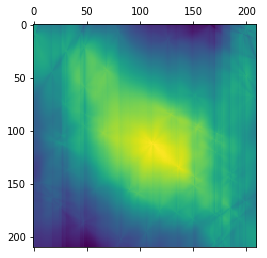

 55/300 [ 18%] █████                          ETA: 1345s

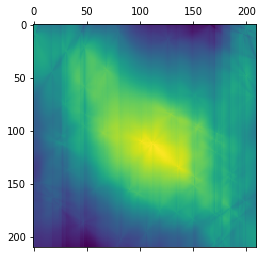

 56/300 [ 18%] █████                          ETA: 1345s

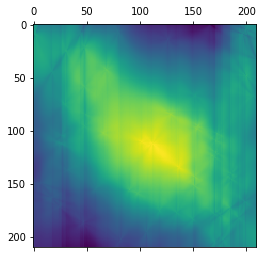

 57/300 [ 19%] █████                          ETA: 1343s

In [ ]:
#i = 0
prob = np.zeros(grid_20.shape[0])
pbar = Progbar(300)
for i in range(300):
    pbar.update(i)
    dis = (grid_glxy_l2diff(grid_20, all_sky_star[2][i][1:3])/4200.).astype(np.float32)
    atan = grid_glxy_arctan(grid_20, all_sky_star[2][i][1:3])
    b2d = np.log(r_list[i].prob(dis.tolist()).eval())
    c2d = np.log(p_list[i].prob(atan.tolist()).eval()*dis**(-1/2.))
#    prob=prob+b2d
    prob=prob+c2d
    plt.clf()
#print(a.shape, b.shape)
    plt.matshow(prob)
#plt.savefig("what.pdf")
    plt.show()
print(all_sky_star[2][i][1:3])

In [ ]:
plt.matshow(prob)
#plt.savefig("what.pdf")  
plt.show()

In [186]:
print(all_sky_star[2].shape)

(578, 5)
